In [1]:
import pandas as pd
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
from sklearn.neighbors import KernelDensity
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
continuous_dataset = pd.read_csv('./archive/continuous dataset.csv')

df1 = continuous_dataset.copy()
df1["datecolumn"] = pd.to_datetime(df1["datetime"])
df1 = df1.sort_values(by='datecolumn', ascending=True)

# Extract components from the datetime
df1['hour'] = df1['datecolumn'].dt.hour
df1['day_of_week'] = df1['datecolumn'].dt.dayofweek
df1['day'] = df1['datecolumn'].dt.day
df1['month'] = df1['datecolumn'].dt.month
df1['year'] = df1['datecolumn'].dt.year

# Apply cyclical encoding
df1['hour_sin'] = np.sin(2 * np.pi * df1['hour'] / 24)
df1['hour_cos'] = np.cos(2 * np.pi * df1['hour'] / 24)
df1['day_of_week_sin'] = np.sin(2 * np.pi * df1['day_of_week'] / 7)
df1['day_of_week_cos'] = np.cos(2 * np.pi * df1['day_of_week'] / 7)
max_day = 31  # Maximum number of days in a month
df1['day_sin'] = np.sin(2 * np.pi * df1['day'] / max_day)
df1['day_cos'] = np.cos(2 * np.pi * df1['day'] / max_day)
df1['month_sin'] = np.sin(2 * np.pi * df1['month'] / 12)
df1['month_cos'] = np.cos(2 * np.pi * df1['month'] / 12)

df1.drop(['datetime', 'datecolumn', 'hour', 'day_of_week', 'day', 'month'], axis=1, inplace=True)

In [3]:
df1.head()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,school,year,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos
0,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,...,0,2015,0.258819,0.965926,-0.974928,-0.222521,0.571268,0.820763,0.5,0.866025
1,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,...,0,2015,0.500000,0.866025,-0.974928,-0.222521,0.571268,0.820763,0.5,0.866025
2,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,...,0,2015,0.707107,0.707107,-0.974928,-0.222521,0.571268,0.820763,0.5,0.866025
3,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,...,0,2015,0.866025,0.500000,-0.974928,-0.222521,0.571268,0.820763,0.5,0.866025
4,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,...,0,2015,0.965926,0.258819,-0.974928,-0.222521,0.571268,0.820763,0.5,0.866025


In [4]:
df1.describe()

,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,...,school,year,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,month_sin,month_cos
count,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,48048.000000,...,48048.000000,48048.000000,4.804800e+04,4.804800e+04,4.804800e+04,4.804800e+04,4.804800e+04,48048.000000,4.804800e+04,4.804800e+04
mean,1182.868647,27.399111,0.018313,0.079979,13.391049,26.921023,0.017844,0.106265,7.046675,24.719513,...,0.727793,2017.268336,-1.850372e-17,-5.649087e-17,-2.129499e-17,-1.900282e-17,2.011625e-03,-0.021411,5.150858e-02,-1.605391e-02
std,192.068896,1.675462,0.001607,0.065589,7.295502,3.018129,0.001889,0.086293,4.103711,2.414019,...,0.445100,1.596256,7.071141e-01,7.071141e-01,7.071141e-01,7.071141e-01,7.141052e-01,0.699723,7.047891e-01,7.073770e-01
min,85.192500,22.953455,0.012054,0.000000,0.008979,19.765222,0.010247,0.000009,0.060394,19.933740,...,0.000000,2015.000000,-1.000000e+00,-1.000000e+00,-9.749279e-01,-9.009689e-01,-9.987165e-01,-0.994869,-1.000000e+00,-1.000000e+00
25%,1020.056900,26.160455,0.017236,0.026451,7.544958,24.769281,0.016584,0.036819,3.955051,22.954652,...,0.000000,2016.000000,-7.071068e-01,-7.071068e-01,-7.818315e-01,-9.009689e-01,-7.247928e-01,-0.758758,-5.000000e-01,-8.660254e-01
50%,1168.427700,27.118051,0.018590,0.065201,12.182103,26.167352,0.018351,0.085968,5.992762,24.001718,...,1.000000,2017.000000,6.123234e-17,-6.123234e-17,0.000000e+00,-2.225209e-01,-2.449294e-16,-0.050649,1.224647e-16,-1.836970e-16
75%,1327.563950,28.558344,0.019521,0.117310,18.661282,28.712335,0.019242,0.157288,9.409871,26.243402,...,1.000000,2019.000000,7.071068e-01,7.071068e-01,7.818315e-01,6.234898e-01,7.247928e-01,0.688967,8.660254e-01,5.000000e-01
max,1754.882000,35.039575,0.022690,0.521240,39.229726,39.063440,0.022165,0.484985,24.483937,34.216211,...,1.000000,2020.000000,1.000000e+00,1.000000e+00,9.749279e-01,1.000000e+00,9.987165e-01,1.000000,1.000000e+00,1.000000e+00


In [5]:
df1.drop(columns=['T2M_san','T2M_dav','QV2M_san','QV2M_dav'], inplace=True)

In [6]:
# get feature names
features = df1.columns
features = features.drop(['nat_demand', 'holiday', 'school',
       'year', 'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos',
       'day_sin', 'day_cos', 'month_sin', 'month_cos'])

In [7]:
scaler = MinMaxScaler().fit(df1[features])
df1[features] = scaler.transform(df1[features])

In [8]:
train_data = df1[df1['year'] == 2016]
test_data = df1[df1['year'] == 2017].reset_index(drop=True)

X_train = train_data.drop(columns=['nat_demand'])
y_train = train_data['nat_demand']

X_test = test_data.drop(columns=['nat_demand'])
y_test = test_data['nat_demand']

In [9]:
def create_sequences(features, targets, n_steps):
    X, y = [], []
    for i in range(len(features) - n_steps):
        X.append(features.iloc[i:(i + n_steps)].values)  # Ensure to use .iloc and .values to get the slice as a NumPy array
        y.append(targets.iloc[i + n_steps])  # Access the corresponding target value
    return np.array(X), np.array(y)

n_steps = 24
x, y = create_sequences(X_train, y_train, n_steps)

In [10]:
# 定义创建随机序列的函数
def create_random_sequences(x, y, n_samples, n_steps=24):
    X, Y = [], []
    max_index = len(x) - 1
    
    for _ in range(n_samples):
        # 随机选择一个目标点的索引，但要确保有足够的前序数据点
        target_index = np.random.randint(n_steps, max_index)
        
        # 提取目标值
        target_value = y[target_index]
        
        # 提取前24小时的特征数据
        feature_values = x[target_index-n_steps:target_index]
        
        # 检查是否有缺失值，如果有则跳过该样本
        if np.isnan(feature_values.values).any():
            continue
        
        X.append(feature_values)
        Y.append(target_value)
    
    return np.array(X), np.array(Y)

# 设定提取样本数量
n_samples = 30  # 你想要的样本数量

# 创建特征和目标
X_t, Y_t = create_random_sequences(X_test, y_test, n_samples)

In [11]:
class LASSOQRLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LASSOQRLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [12]:
X_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_t, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_t, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_tensor, y_tensor)
t_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_size = int(0.8 * len(t_dataset))
val_size = len(t_dataset) - test_size
test_dataset, val_dataset = random_split(t_dataset, [test_size, val_size])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, drop_last=False)

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [14]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 初始化隐藏状态和细胞状态
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()
        # 分离隐藏状态，以避免梯度爆炸
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # 在评估模式下打印全连接层的输入
        if not self.training:
            print("Input to the fully connected layer (eval mode):", out[:, -1, :])
        out = self.fc(out[:, -1, :])  # 只取序列的最后一个输出
        return out

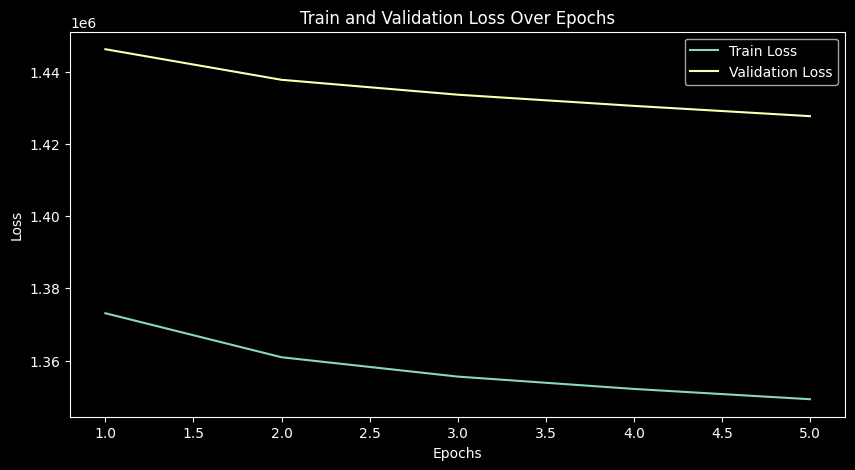

Epoch 5, Train Loss: 1349277.6397125912, Val Loss: 1427728.7083333333


Epoch 6/50:  35%|███▍      | 190/548 [00:02<00:04, 85.96batch/s, train_loss=1.22e+6]


KeyboardInterrupt: 

In [15]:
# 设置设备
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps")

# 初始化模型并移动到设备
input_dim = X_tensor.shape[2]  # 特征数
hidden_dim = 200  # 隐藏层维度
layer_dim = 2  # LSTM层的数量
output_dim = 1  # 输出维度

model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).to(device)

# 定义损失函数和优化器
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# 训练模型并记录损失
num_epochs = 50  # 根据需要调整
train_losses = []
val_losses = []

plt.ion()  # 打开交互模式

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
    for features, targets in progress_bar:
        features, targets = features.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_function(outputs, targets)
        loss.backward()

        # 应用梯度裁剪
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            loss = loss_function(outputs, targets)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

plt.ioff()  # 关闭交互模式
plt.show()  # 确保最后一张图表显示

print("Training complete.")

In [16]:
# 应用模型在测试集上
model.eval()
predictions = []
true_values = []

with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy())
        true_values.extend(targets.cpu().numpy())

# 转换为numpy数组
predictions = np.array(predictions)
true_values = np.array(true_values)

# 计算RMSE
rmse = np.sqrt(mean_squared_error(true_values, predictions))
print(f"RMSE on test data: {rmse}")

# 打印预测值和真实值
for i in range(len(predictions)):
    print(f"Predicted: {predictions[i]}, Actual: {true_values[i]}")

Input to the fully connected layer (eval mode): tensor([[-0.9924, -0.9885, -0.9909, -0.9856,  0.9892, -0.9917, -0.9888, -0.9927,
         -0.9944,  0.9827, -0.9891,  0.9935,  0.9915, -0.9883, -0.9883, -0.9916,
          0.9944,  0.9951, -0.9867, -0.9856,  0.9949,  0.9873,  0.9840, -0.9861,
         -0.9939, -0.9918,  0.9890,  0.9933, -0.9955,  0.9927,  0.9928,  0.9882,
          0.9909,  0.9925, -0.9938,  0.9968,  0.9948, -0.9928,  0.9895,  0.9885,
          0.9910,  0.9952,  0.9926,  0.9956, -0.9892, -0.9931, -0.9918, -0.9944,
          0.9946,  0.9929,  0.9874, -0.9918,  0.9820,  0.9917,  0.9946,  0.9930,
         -0.9955,  0.9928,  0.9877,  0.9955,  0.9910, -0.9883,  0.9937,  0.9923,
         -0.9914,  0.9875, -0.9946, -0.9924,  0.9958, -0.9867,  0.9837, -0.9862,
         -0.9861,  0.9949, -0.9938, -0.9903, -0.9895, -0.9915, -0.9952, -0.9903,
         -0.9885,  0.9922,  0.9937, -0.9911,  0.9908, -0.9928,  0.9901, -0.9955,
          0.9959,  0.9964, -0.9912,  0.9900,  0.9948, -0.9924

In [11]:
def sliding_window(data, window_size, step_size):
    X, Y = [], []
    for i in range(0, len(data) - window_size, step_size):
        X.append(data[i:(i + window_size - 1)])
        Y.append(data[i + window_size])
    return np.array(X), np.array(Y)

In [19]:
# # 参数空间定义
# param_space = [
#     Real(0.001, 0.1, name='learning_rate'),
#     Integer(10, 100, name='hidden_dim')
# ]

# @use_named_args(param_space)
# def objective(learning_rate, hidden_dim):
#     model = LASSOQRLSTM(input_dim=X.shape[2], hidden_dim=hidden_dim, output_dim=Y.shape[1])
#     # 使用数据集和定义的训练函数
#     return train_model(model, dataloader, learning_rate)

# # 调用贝叶斯优化
# result = gp_minimize(objective, param_space, n_calls=20)
# print("Best parameters:", result.x)


def train_model(model, dataloader, learning_rate, epochs=5):
    criterion = nn.MSELoss()  # 假设是回归问题
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Average Loss: {total_loss / len(dataloader)}")
    return total_loss / len(dataloader)


result = gp_minimize(objective, param_space, n_calls=20)

NameError: name 'objective' is not defined

In [ ]:
model = LASSOQRLSTM(input_dim=X.shape[2], hidden_dim=result.x[1], output_dim=Y.shape[1])
# 假设 train_model 已经足够好地定义了
train_model(model, dataloader, result.x[0])

In [ ]:
from sklearn.neighbors import KernelDensity

def predict_density(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data).numpy()
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
    kde.fit(predictions)
    return kde

# 为了预测，转换数据为张量
data_tensor = torch.tensor(X, dtype=torch.float32)
kde_estimator = predict_density(model, data_tensor)